In [17]:
from __future__ import division
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
import sklearn as sk
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
import warnings # to silence convergence warnings
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import missingno as msno

from functions import *

import math


sns.set() # Set searborn as default

%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

## Load data

In [2]:
df_initial = pd.read_csv('./case1Data.txt',delimiter=',',header=0, na_values=[' NaN'])
df = df_initial.copy()
df_initial
df.keys

categories = df.keys()[-5:].to_list()
categories


[' C_ 1', ' C_ 2', ' C_ 3', ' C_ 4', ' C_ 5']

## Missing values

<Axes: >

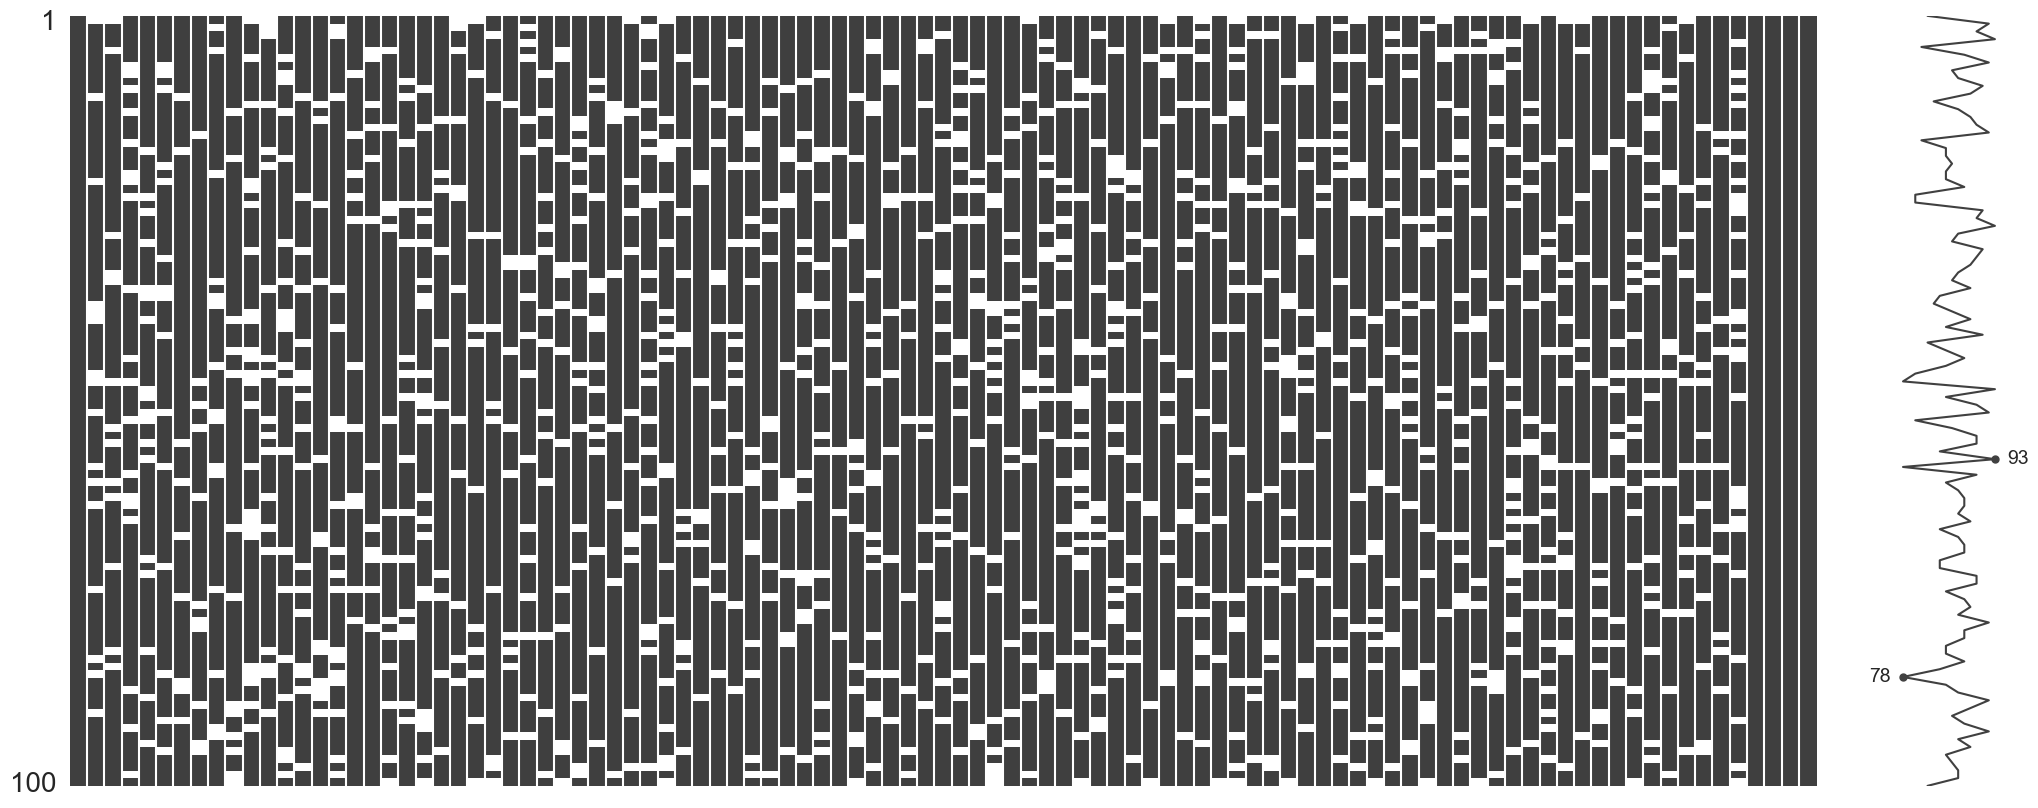

In [3]:
msno.matrix(df)

## Model selection

### OLS 

In [15]:

data = df_initial.copy()


y = data.iloc[:,0].to_numpy()
X = data.iloc[:,1:].to_numpy()


K = 5
CV = KFold(n_splits=K,shuffle=True)
X_standardizer = StandardScaler()

train_RSS = [0]*K
test_RSS = [0]*K
train_R2 = [0]*K
test_R2 = [0]*K
train_MSE = [0]*K
test_MSE = [0]*K
train_TSS = [0]*K
test_TSS = [0]*K

for i, (train_index, test_index) in enumerate(CV.split(X,y)):

    # Deal with missing values and categorical values

    X_train  = preprocessing(pd.DataFrame(X[train_index,:])).values
    Y_train  = y[train_index]
    X_test   = preprocessing(pd.DataFrame(X[test_index,:])).values
    Y_test   = y[test_index]

    # Normalization

    print(len(X_train[0]))
    print(len(X_test[0]))

    X_train = X_standardizer.fit_transform(X_train)
    X_test = X_standardizer.transform(X_test)

    


    
    beta, error, rank, eigenval = np.linalg.lstsq(X_train.astype('float'), Y_train, rcond=None)
    yhat = X_train @ beta

    train_RSS[i]   = RSS(Y_train,yhat)
    test_RSS[i]    = RSS(Y_test,yhat)
    train_R2[i]    = R2(Y_train,yhat) 
    test_R2[i]     = R2(Y_test,yhat) 
    train_MSE[i]   = MSE(Y_train,yhat)
    test_MSE[i]    = MSE(Y_test,yhat)
    test_TSS[i]    = TSS(Y_test)
    train_TSS[i]   = TSS(Y_train)

    

fig, axs = plt.subplots(3, 1, figsize=(8, 18))

# Plot (Train R2 and Test R2)
axs[0].scatter(range(K), train_R2, label='Train R2', marker='o')
axs[0].scatter(range(K), test_R2, label='Test R2', marker='o')
axs[0].set_title('Train R2 vs Test R2')
axs[0].set_xlabel('Split')
axs[0].set_ylabel('R2')
axs[0].legend()

# Plot (Train MSE and Test MSE)
axs[1].scatter(range(K), train_MSE, label='Train MSE', marker='o')
axs[1].scatter(range(K), test_MSE, label='Test MSE', marker='o')
axs[1].set_title('Train MSE vs Test MSE')
axs[1].set_xlabel('Split')
axs[1].set_ylabel('MSE')
axs[1].legend()

# Plot (Train RSS and Test RSS)
axs[2].scatter(range(K), train_RSS, label='Train RSS', marker='o')
axs[2].scatter(range(K), test_RSS, label='Test RSS', marker='o')
axs[2].set_title('Train RSS vs Test RSS')
axs[2].set_xlabel('Split')
axs[2].set_ylabel('RSS')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()





116
116
116
115


ValueError: X has 115 features, but StandardScaler is expecting 116 features as input.

In [ ]:

test_R2[2]
train_R2[2]

test_RSS[2]


62199.75253734218

In [ ]:
# First, just standard OLS

MSE(y,yhat)


1.678832619762765e-25

In [ ]:
K = 10
CV = StratifiedKFold(n_splits=K,shuffle=True)
X_standardizer = StandardScaler()

with warnings.catch_warnings(): # done to disable all the convergence warnings from elastic net
    warnings.simplefilter("ignore")

for i, (train_index, test_index) in enumerate(CV.split(X,y)):
    
    X_train  = X[train_index,:]
    Y_train  = y[train_index]
    X_test   = X[test_index,:]
    Y_test   = y[test_index]

    
            

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

[101.2782,
 135.6969,
 134.59261675866557,
 347.6251333590584,
 533.3730323787379,
 608.9303456611981,
 630.7156331405182,
 629.3741313325598,
 507.6080310714912,
 374.52313103379294,
 280.0173310283493,
 107.73473102756323]